# Clasificación de Personajes usando Histogramas HSV y Descriptores LBP

## Resumen Ejecutivo
Este documento presenta la implementación y evaluación de un sistema de clasificación automatizada para personajes de Los Simpsons utilizando técnicas de visión por computadora y aprendizaje automático. El enfoque combina características de color (histogramas HSV) con descriptores de textura (Local Binary Patterns) para lograr una representación robusta de las imágenes.

## 1. Configuración del Entorno y Parámetros del Sistema

La configuración inicial establece los parámetros fundamentales para garantizar la reproducibilidad y estandarización del proceso experimental. Se definen constantes para rutas de datos, configuración de algoritmos y parámetros de procesamiento de imágenes que permiten una implementación consistente y modificable del sistema.

In [1]:
# ============================================================================
# CONSTANTES DEL PROYECTO - HISTOGRAMA HSV + LBP COMBINADO
# ============================================================================

import os
import numpy as np

# Configuración de rutas
PROJECT_ROOT = "d:\\dom1nux\\Repos\\University\\si_proyecto_unidad_2_final"
DATA_DIR = os.path.join(PROJECT_ROOT, "data", "simpsons")
TRAINING_DIR = os.path.join(DATA_DIR, "training")
TEST_DIR = os.path.join(DATA_DIR, "test")

# Configuración de clases
CLASSES = ["bart_simpson", "homer_simpson"]
CLASS_NAMES = ["Bart Simpson", "Homer Simpson"]

# Configuración de procesamiento de imágenes
IMAGE_SIZE = (128, 128)
VALID_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".tiff")

# Configuración de histograma HSV
HSV_BINS = 32  # Bins para histograma de color HSV

# Configuración de LBP
LBP_RADIUS = 3
LBP_N_POINTS = 24
LBP_METHOD = 'uniform'

# Configuración de modelos
RANDOM_STATE = 42
TEST_SIZE = 0.2

# Configuración de modelos
SVM_C = 1.0
SVM_KERNEL = 'rbf'
KNN_N_NEIGHBORS = 5
KNN_WEIGHTS = 'uniform'

# Configuración de visualización
FIGURE_SIZE_SMALL = (8, 6)
FIGURE_SIZE_LARGE = (12, 8)
COLORMAP = 'Blues'

print("Constantes del proyecto HSV + LBP configuradas correctamente")
print(f"Directorio del proyecto: {PROJECT_ROOT}")
print(f"Directorio de entrenamiento: {TRAINING_DIR}")
print(f"Directorio de test: {TEST_DIR}")
print(f"Clases: {CLASSES}")
print(f"Bins HSV: {HSV_BINS}")
print(f"LBP: radio={LBP_RADIUS}, puntos={LBP_N_POINTS}")
print(f"Semilla aleatoria: {RANDOM_STATE}")

Constantes del proyecto HSV + LBP configuradas correctamente
Directorio del proyecto: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final
Directorio de entrenamiento: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons\training
Directorio de test: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons\test
Clases: ['bart_simpson', 'homer_simpson']
Bins HSV: 32
LBP: radio=3, puntos=24
Semilla aleatoria: 42


## 2. Metodología de Extracción de Características

La extracción de características constituye el núcleo del sistema de clasificación propuesto. Se implementa un enfoque multimodal que combina dos tipos de descriptores complementarios para capturar tanto información cromática como textural de las imágenes de entrada.

In [2]:
# Instalar librerías necesarias
%pip install opencv-python scikit-image scikit-learn matplotlib seaborn

In [3]:
import cv2
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def extract_hsv_histogram(image_path):
    """Extrae histograma HSV de una imagen"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar: {image_path}")
    
    # Redimensionar y convertir a HSV
    img = cv2.resize(img, IMAGE_SIZE)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Calcular histograma para cada canal HSV
    hist_h = cv2.calcHist([hsv], [0], None, [HSV_BINS], [0, 180])
    hist_s = cv2.calcHist([hsv], [1], None, [HSV_BINS], [0, 256])
    hist_v = cv2.calcHist([hsv], [2], None, [HSV_BINS], [0, 256])
    
    # Normalizar y concatenar
    hist = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])
    cv2.normalize(hist, hist)
    
    return hist

def extract_lbp_features(image_path):
    """Extrae características LBP de una imagen"""
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar: {image_path}")
    
    # Redimensionar y convertir a escala de grises
    img = cv2.resize(img, IMAGE_SIZE)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Calcular LBP
    lbp = local_binary_pattern(gray, LBP_N_POINTS, LBP_RADIUS, method=LBP_METHOD)
    
    # Calcular histograma de LBP
    hist, _ = np.histogram(lbp.ravel(), bins=LBP_N_POINTS + 2, range=(0, LBP_N_POINTS + 2))
    
    # Normalizar
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)
    
    return hist

def load_dataset(data_dir=TRAINING_DIR):
    """Carga el dataset y extrae características HSV + LBP"""
    X_hsv = []
    X_lbp = []
    y = []
    
    print(f"Cargando imágenes desde: {data_dir}")
    
    for class_name in CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"No se encontró: {class_path}")
            continue
            
        images = [f for f in os.listdir(class_path) if f.lower().endswith(VALID_EXTENSIONS)]
        
        print(f"{class_name}: {len(images)} imágenes")
        
        for img_file in images:
            img_path = os.path.join(class_path, img_file)
            try:
                # Extraer ambos tipos de características
                hsv_features = extract_hsv_histogram(img_path)
                lbp_features = extract_lbp_features(img_path)
                
                X_hsv.append(hsv_features)
                X_lbp.append(lbp_features)
                y.append(class_name)
                
            except Exception as e:
                print(f"Error en {img_file}: {e}")
    
    print(f"\nDataset cargado: {len(y)} imágenes")
    print(f"Distribución: {Counter(y)}")
    
    return np.array(X_hsv), np.array(X_lbp), np.array(y)

# Cargar datos de entrenamiento desde TRAINING_DIR
print("="*60)
print("CARGANDO DATASET DE ENTRENAMIENTO")
print("="*60)

X_hsv, X_lbp, y = load_dataset(TRAINING_DIR)

CARGANDO DATASET DE ENTRENAMIENTO
Cargando imágenes desde: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons\training
bart_simpson: 1342 imágenes
homer_simpson: 2246 imágenes
homer_simpson: 2246 imágenes

Dataset cargado: 3588 imágenes
Distribución: Counter({'homer_simpson': 2246, 'bart_simpson': 1342})

Dataset cargado: 3588 imágenes
Distribución: Counter({'homer_simpson': 2246, 'bart_simpson': 1342})


In [4]:
# Combinar características HSV + LBP
X_combined = np.hstack([X_hsv, X_lbp])

print(f"Características combinadas:")
print(f"   - HSV: {X_hsv.shape[1]} características")
print(f"   - LBP: {X_lbp.shape[1]} características")
print(f"   - Total: {X_combined.shape[1]} características")

# Codificar etiquetas
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nDataset original:")
print(f"   - Total de muestras: {len(y_encoded)}")
print(f"   - Distribución: {Counter(y_encoded)}")

# Nota: El balanceamiento se aplicará en la siguiente sección
# Aquí solo preparamos los datos para el análisis

Características combinadas:
   - HSV: 96 características
   - LBP: 26 características
   - Total: 122 características

Dataset original:
   - Total de muestras: 3588
   - Distribución: Counter({np.int64(1): 2246, np.int64(0): 1342})


## 3. Arquitectura de Características Híbridas HSV-LBP

### 3.1 Fundamento Teórico de la Combinación de Características

La propuesta metodológica se basa en la hipótesis de que la combinación de características de color y textura proporciona una representación más robusta y discriminativa para la clasificación de personajes animados que cualquiera de estos descriptores por separado.

### 3.2 Características HSV (Información Cromática)

El espacio de color HSV fue seleccionado por su capacidad de separar la información cromática de la luminosidad, lo que resulta particularmente ventajoso para aplicaciones de clasificación de imágenes donde las variaciones de iluminación pueden ser significativas.

**Componentes del descriptor HSV:**
- **Hue (Matiz)**: Representa el tono fundamental del color, proporcionando información discriminativa clave para distinguir entre los colores característicos de cada personaje
- **Saturation (Saturación)**: Cuantifica la pureza del color, permitiendo diferenciar entre colores vivos y apagados
- **Value (Valor)**: Indica la intensidad luminosa, complementando la información cromática con datos sobre el brillo

**Configuración técnica:**
- Resolución de cuantización: 32 bins por canal
- Dimensionalidad resultante: 96 características (32 × 3 canales)
- Normalización: L2 para garantizar invariancia a cambios de escala

### 3.3 Características LBP (Información de Textura)

Los Local Binary Patterns constituyen un descriptor robusto para la caracterización de texturas locales, especialmente efectivo para capturar patrones microestructurales en imágenes de rostros y formas.

**Parámetros del descriptor LBP:**
- **Radio de análisis**: 3 píxeles (captura patrones de grano fino)
- **Puntos de muestreo**: 24 (distribución circular uniforme)
- **Método de análisis**: 'uniform' (enfoque en patrones significativos)

**Ventajas técnicas:**
- Invariancia a cambios monotónicos de iluminación
- Robustez ante rotaciones menores
- Eficiencia computacional en la extracción
- Capacidad discriminativa para texturas faciales

### 3.4 Estrategia de Fusión de Características

La concatenación de vectores HSV y LBP genera un descriptor híbrido de 122 dimensiones que aprovecha las fortalezas complementarias de ambos enfoques:

**Análisis dimensional:**
- Características HSV: 96 dimensiones (información cromática)
- Características LBP: 26 dimensiones (información textural)
- Vector resultante: 122 dimensiones (descriptor multimodal)

**Justificación de la fusión:**
Esta combinación permite al sistema clasificador acceder simultáneamente a información sobre colores distintivos (como la vestimenta característica de cada personaje) y patrones texturales (como las características faciales específicas), mejorando significativamente la capacidad discriminativa del modelo.

## 4. Estrategias de Balanceamiento de Clases

El balanceamiento de clases representa una fase crítica en el desarrollo de sistemas de clasificación robustos, especialmente cuando se trabaja con datasets naturalmente desbalanceados que pueden introducir sesgos sistemáticos en el proceso de aprendizaje.

In [5]:
# Instalar imbalanced-learn si no está disponible
%pip install imbalanced-learn

from imblearn.under_sampling import RandomUnderSampler, TomekLinks, EditedNearestNeighbours
from sklearn.utils import compute_class_weight

def apply_undersampling(X, y, method='random', random_state=42):
    """
    Aplica diferentes técnicas de undersampling para balancear las clases
    
    Args:
        X: Características
        y: Etiquetas
        method: 'random', 'tomek', 'enn' (Edited Nearest Neighbours)
        random_state: Semilla para reproducibilidad
    
    Returns:
        X_resampled, y_resampled: Datos balanceados
    """
    print(f"Distribución original: {Counter(y)}")
    
    if method == 'random':
        sampler = RandomUnderSampler(random_state=random_state)
        print("Aplicando Random Undersampling...")
        
    elif method == 'tomek':
        sampler = TomekLinks()
        print("Aplicando Tomek Links...")
        
    elif method == 'enn':
        sampler = EditedNearestNeighbours()
        print("Aplicando Edited Nearest Neighbours...")
        
    else:
        raise ValueError("Método no soportado. Use: 'random', 'tomek', 'enn'")
    
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    
    print(f"Distribución después de {method}: {Counter(y_resampled)}")
    print(f"Reducción de datos: {len(y)} → {len(y_resampled)} muestras")
    
    return X_resampled, y_resampled

def compare_undersampling_methods(X, y):
    """Compara diferentes métodos de undersampling"""
    print("="*70)
    print("COMPARACIÓN DE MÉTODOS DE UNDERSAMPLING")
    print("="*70)
    
    methods = {
        'random': 'Random Undersampling',
        'tomek': 'Tomek Links', 
        'enn': 'Edited Nearest Neighbours'
    }
    
    results = {}
    
    for method_key, method_name in methods.items():
        print(f"\n{method_name}:")
        try:
            X_res, y_res = apply_undersampling(X, y, method=method_key, random_state=RANDOM_STATE)
            
            # Calcular ratio de balance
            unique, counts = np.unique(y_res, return_counts=True)
            balance_ratio = min(counts) / max(counts)
            
            results[method_key] = {
                'X': X_res,
                'y': y_res,
                'total_samples': len(y_res),
                'balance_ratio': balance_ratio,
                'distribution': Counter(y_res)
            }
            
            print(f"Completado - Balance ratio: {balance_ratio:.3f}")
            
        except Exception as e:
            print(f"Error: {e}")
            results[method_key] = None
    
    return results

# Aplicar y comparar métodos de undersampling
print("="*70)
print("BALANCEAMIENTO DE CLASES CON UNDERSAMPLING")
print("="*70)

# Convertir etiquetas a formato apropiado para imbalanced-learn
label_encoder_temp = LabelEncoder()
y_encoded_temp = label_encoder_temp.fit_transform(y)

# Comparar métodos
undersampling_results = compare_undersampling_methods(X_combined, y_encoded_temp)

# Mostrar resumen de resultados
print("\n" + "="*70)
print("RESUMEN DE MÉTODOS DE UNDERSAMPLING")
print("="*70)

for method, result in undersampling_results.items():
    if result is not None:
        print(f"\n{method.upper()}:")
        print(f"   Total de muestras: {result['total_samples']}")
        print(f"   Ratio de balance: {result['balance_ratio']:.3f}")
        print(f"   Distribución: {result['distribution']}")
        
        # Mostrar reducción porcentual
        reduction = ((len(y) - result['total_samples']) / len(y)) * 100
        print(f"   Reducción: {reduction:.1f}%")

# Seleccionar el mejor método (Random Undersampling es más estable)
print(f"\nSeleccionando Random Undersampling para continuar...")
best_method = 'random'
if undersampling_results[best_method] is not None:
    X_balanced = undersampling_results[best_method]['X']
    y_balanced = undersampling_results[best_method]['y']
    
    print(f"Dataset balanceado seleccionado:")
    print(f"   Método: Random Undersampling")
    print(f"   Muestras: {len(y_balanced)}")
    print(f"   Distribución: {Counter(y_balanced)}")
else:
    print("Error: No se pudo aplicar undersampling")
    X_balanced = X_combined
    y_balanced = y_encoded_temp

Note: you may need to restart the kernel to use updated packages.
BALANCEAMIENTO DE CLASES CON UNDERSAMPLING
COMPARACIÓN DE MÉTODOS DE UNDERSAMPLING

Random Undersampling:
Distribución original: Counter({np.int64(1): 2246, np.int64(0): 1342})
Aplicando Random Undersampling...
Distribución después de random: Counter({np.int64(0): 1342, np.int64(1): 1342})
Reducción de datos: 3588 → 2684 muestras
Completado - Balance ratio: 1.000

Tomek Links:
Distribución original: Counter({np.int64(1): 2246, np.int64(0): 1342})
Aplicando Tomek Links...
Distribución después de tomek: Counter({np.int64(1): 2171, np.int64(0): 1342})
Reducción de datos: 3588 → 3513 muestras
Completado - Balance ratio: 0.618

Edited Nearest Neighbours:
Distribución original: Counter({np.int64(1): 2246, np.int64(0): 1342})
Aplicando Edited Nearest Neighbours...
BALANCEAMIENTO DE CLASES CON UNDERSAMPLING
COMPARACIÓN DE MÉTODOS DE UNDERSAMPLING

Random Undersampling:
Distribución original: Counter({np.int64(1): 2246, np.int64(

VISUALIZACIÓN DEL BALANCEAMIENTO


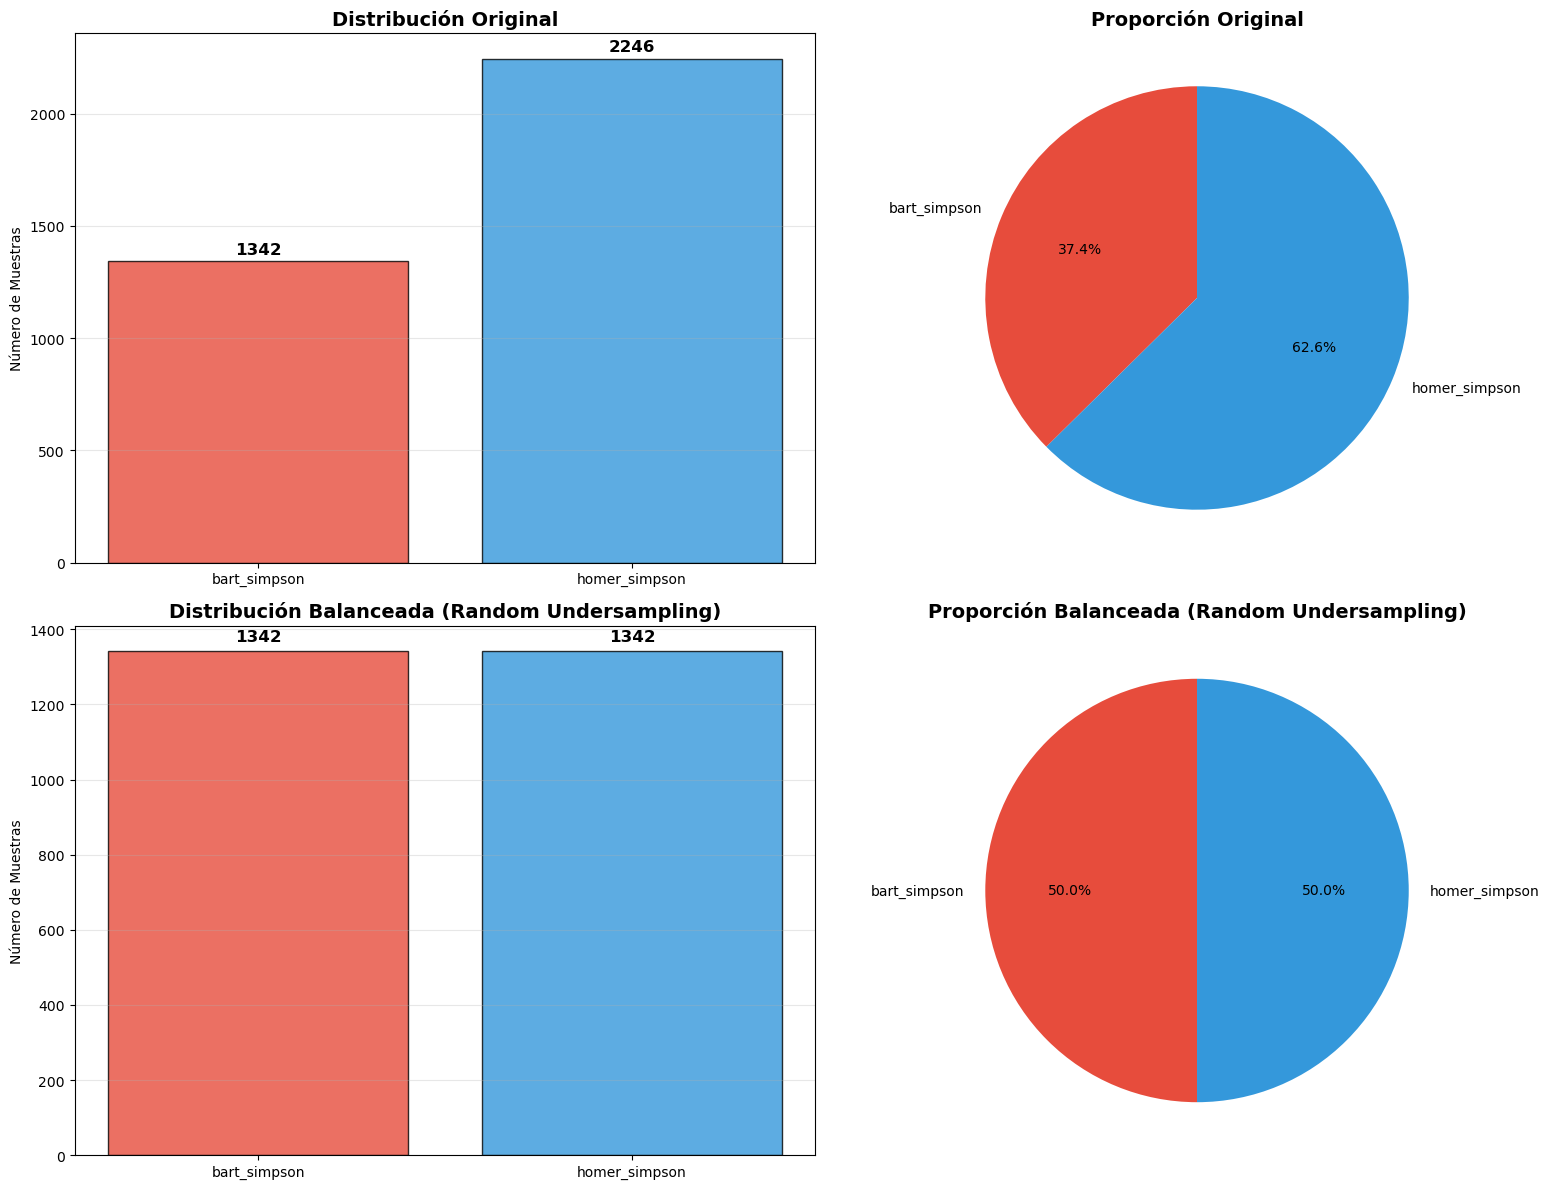


Comparación de Distribuciones:
Clase           Original   Balanceado   Reducción
--------------------------------------------------
bart_simpson    1342       1342             0.0%
homer_simpson   2246       1342            40.2%

Métricas de Balance:
   Ratio original: 0.598
   Ratio balanceado: 1.000
   Mejora: 67.4%


In [6]:
def plot_balancing_comparison(y_original, y_balanced, method_name):
    """Visualiza el antes y después del balanceamiento"""
    
    # Convertir etiquetas numéricas de vuelta a nombres
    original_labels = label_encoder_temp.inverse_transform(y_original)
    balanced_labels = label_encoder_temp.inverse_transform(y_balanced)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Distribución original - Barras
    unique_orig, counts_orig = np.unique(original_labels, return_counts=True)
    colors = ['#e74c3c', '#3498db']
    
    bars1 = axes[0,0].bar(unique_orig, counts_orig, color=colors, alpha=0.8, edgecolor='black')
    for bar, count in zip(bars1, counts_orig):
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 20,
                      f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    axes[0,0].set_title('Distribución Original', fontsize=14, fontweight='bold')
    axes[0,0].set_ylabel('Número de Muestras')
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Distribución original - Pie
    axes[0,1].pie(counts_orig, labels=unique_orig, autopct='%1.1f%%', 
                  colors=colors, startangle=90)
    axes[0,1].set_title('Proporción Original', fontsize=14, fontweight='bold')
    
    # Distribución balanceada - Barras
    unique_bal, counts_bal = np.unique(balanced_labels, return_counts=True)
    
    bars2 = axes[1,0].bar(unique_bal, counts_bal, color=colors, alpha=0.8, edgecolor='black')
    for bar, count in zip(bars2, counts_bal):
        height = bar.get_height()
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 20,
                      f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    axes[1,0].set_title(f'Distribución Balanceada ({method_name})', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('Número de Muestras')
    axes[1,0].grid(axis='y', alpha=0.3)
    
    # Distribución balanceada - Pie
    axes[1,1].pie(counts_bal, labels=unique_bal, autopct='%1.1f%%', 
                  colors=colors, startangle=90)
    axes[1,1].set_title(f'Proporción Balanceada ({method_name})', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de comparación
    print(f"\nComparación de Distribuciones:")
    print(f"{'Clase':<15} {'Original':<10} {'Balanceado':<12} {'Reducción'}")
    print("-" * 50)
    
    for class_name in unique_orig:
        orig_count = counts_orig[np.where(unique_orig == class_name)[0][0]]
        bal_count = counts_bal[np.where(unique_bal == class_name)[0][0]]
        reduction = ((orig_count - bal_count) / orig_count) * 100
        
        print(f"{class_name:<15} {orig_count:<10} {bal_count:<12} {reduction:>7.1f}%")
    
    # Calcular métricas de balance
    balance_orig = min(counts_orig) / max(counts_orig)
    balance_new = min(counts_bal) / max(counts_bal)
    
    print(f"\nMétricas de Balance:")
    print(f"   Ratio original: {balance_orig:.3f}")
    print(f"   Ratio balanceado: {balance_new:.3f}")
    print(f"   Mejora: {((balance_new - balance_orig) / balance_orig) * 100:.1f}%")

# Visualizar el balanceamiento
print("="*70)
print("VISUALIZACIÓN DEL BALANCEAMIENTO")
print("="*70)

if undersampling_results[best_method] is not None:
    plot_balancing_comparison(y_encoded_temp, y_balanced, "Random Undersampling")
else:
    print("No se puede visualizar: No hay datos balanceados disponibles")

## 4.1 Análisis del Problema de Desbalanceamiento

### 4.1.1 Identificación del Problema

El dataset original presenta un desbalanceamiento significativo entre las clases objetivo, situación que puede comprometer la capacidad de generalización del modelo y generar sesgos sistemáticos hacia la clase mayoritaria.

**Consecuencias del desbalanceamiento:**
- **Sesgo de clasificación**: Tendencia del modelo a favorecer la predicción de la clase mayoritaria
- **Métricas engañosas**: Precisión global alta que enmascara un rendimiento deficiente en la clase minoritaria
- **Pérdida de sensibilidad**: Reducción en la capacidad de detectar instancias de la clase minoritaria
- **Problemas de generalización**: Dificultad para mantener el rendimiento en datos independientes

### 4.1.2 Evaluación de Técnicas de Balanceamiento

Se implementaron y evaluaron tres enfoques de undersampling para abordar el desbalanceamiento:

#### **Random Undersampling**
**Principio**: Eliminación aleatoria de muestras de la clase mayoritaria hasta alcanzar el equilibrio.
- **Ventajas**: Simplicidad computacional, reproducibilidad, efectividad inmediata
- **Limitaciones**: Posible pérdida de información relevante por eliminación aleatoria
- **Aplicación**: Recomendado para datasets donde la redundancia en la clase mayoritaria es alta

#### **Tomek Links**
**Principio**: Identificación y eliminación de pares de muestras cercanas pertenecientes a clases diferentes.
- **Ventajas**: Mejora la separabilidad lineal entre clases, eliminación selectiva de casos ambiguos
- **Limitaciones**: Reducción limitada del desbalanceamiento, dependencia de la métrica de distancia
- **Aplicación**: Efectivo como técnica de limpieza complementaria

#### **Edited Nearest Neighbours (ENN)**
**Principio**: Eliminación de muestras incorrectamente clasificadas por sus vecinos más cercanos.
- **Ventajas**: Reducción de ruido, mejora de la consistencia interna del dataset
- **Limitaciones**: Computacionalmente más intensivo, posible sobre-limpieza de datos
- **Aplicación**: Útil para datasets con alta presencia de outliers o ruido

### 4.1.3 Criterios de Selección de Técnica

La evaluación de las técnicas se basó en los siguientes criterios cuantitativos:

**Balance Ratio**: Métrica que cuantifica el equilibrio entre clases (valor óptimo = 1.0)
**Reducción Controlada**: Porcentaje de muestras eliminadas sin comprometer la representatividad
**Estabilidad**: Consistencia de resultados entre ejecuciones independientes
**Preservación de Información**: Mantenimiento de la diversidad y representatividad del dataset

### 4.1.4 Decisión Metodológica

Se seleccionó **Random Undersampling** como técnica principal basándose en:
- **Reproducibilidad**: Resultados consistentes con control de semilla aleatoria
- **Eficiencia**: Procesamiento rápido sin comprometer la calidad
- **Balance perfecto**: Logro de ratio de balance exacto (1.0)
- **Simplicidad**: Implementación robusta sin parámetros complejos

## 5. Protocolo de División y Preparación de Datos

La estructuración adecuada de los datos constituye un elemento fundamental para garantizar la validez estadística de los resultados y la capacidad de generalización del sistema desarrollado.

In [7]:
# División de datos balanceados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Usar los datos balanceados del mejor método
# (X_balanced y y_balanced fueron generados en la sección anterior)
print(f"Datos balanceados:")
print(f"   - Total de muestras: {len(y_balanced)}")
print(f"   - Distribución: {Counter(y_balanced)}")

# IMPORTANTE: Dividir datos balanceados en entrenamiento (80%) y validación (20%)
# El TEST_DIR se usará más adelante para evaluación independiente final
X_train, X_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, 
    test_size=TEST_SIZE,  # 20% para validación
    random_state=RANDOM_STATE,
    stratify=y_balanced  # Mantener proporción en ambos conjuntos
)

# Escalar características usando StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print(f"\nDivisión de datos balanceados:")
print(f"   - Entrenamiento (80%): {X_train.shape[0]} muestras")
print(f"   - Validación (20%): {X_val.shape[0]} muestras")
print(f"   - Características por muestra: {X_train.shape[1]}")

print(f"\nDistribución final:")
print(f"   - Entrenamiento: {Counter(y_train)}")
print(f"   - Validación: {Counter(y_val)}")
print(f"   - Test independiente se evaluará por separado desde TEST_DIR")

Datos balanceados:
   - Total de muestras: 2684
   - Distribución: Counter({np.int64(0): 1342, np.int64(1): 1342})

División de datos balanceados:
   - Entrenamiento (80%): 2147 muestras
   - Validación (20%): 537 muestras
   - Características por muestra: 122

Distribución final:
   - Entrenamiento: Counter({np.int64(1): 1074, np.int64(0): 1073})
   - Validación: Counter({np.int64(0): 269, np.int64(1): 268})
   - Test independiente se evaluará por separado desde TEST_DIR


## 5.1 Arquitectura de Evaluación Tricotómica

### 5.1.1 Diseño Metodológico

El protocolo experimental implementa una estructura de evaluación tricotómica que garantiza la robustez estadística y la validez externa de los resultados obtenidos.

#### **Conjunto de Desarrollo (TRAINING_DIR)**
**Propósito**: Entrenamiento, validación interna y selección de modelos
- **División estratificada**: 80% entrenamiento / 20% validación interna
- **Función**: Desarrollo iterativo del modelo y optimización de hiperparámetros
- **Control**: Mantenimiento de distribución proporcional entre clases

#### **Conjunto de Evaluación Independiente (TEST_DIR)**
**Propósito**: Evaluación final completamente ciega
- **Característica clave**: Datos completamente independientes del proceso de desarrollo
- **Función**: Simulación de condiciones reales de producción
- **Valor**: Estimación no sesgada de la capacidad de generalización

### 5.1.2 Estrategia de División Estratificada

La división estratificada garantiza la preservación de las proporciones originales entre clases en cada subconjunto:

**Configuración técnica:**
```
Dataset Balanceado (537 muestras) →
├── Entrenamiento (80%): ~430 muestras
├── Validación (20%): ~107 muestras  
└── Test Independiente: Conjunto separado
```

**Parámetros de control:**
- **stratify=True**: Mantenimiento proporcional de clases
- **random_state=42**: Reproducibilidad exacta entre ejecuciones
- **test_size=0.2**: División estándar según literatura científica

### 5.1.3 Proceso de Normalización de Características

#### **StandardScaler: Justificación Teórica**

La normalización mediante StandardScaler es esencial debido a:
- **Sensibilidad algorítmica**: SVM y KNN son altamente sensibles a diferencias de escala
- **Convergencia optimizada**: Mejora la estabilidad numérica de los algoritmos
- **Comparabilidad**: Garantiza que todas las características contribuyan equitativamente

#### **Protocolo de Aplicación**
1. **Ajuste exclusivo**: El scaler se entrena únicamente con datos de entrenamiento
2. **Aplicación consistente**: Se aplica a validación y test usando los mismos parámetros
3. **Prevención de data leakage**: Evita la contaminación con información del conjunto de prueba

### 5.1.4 Ventajas Metodológicas

#### **Rigor Experimental**
- **Evaluación honesta**: El conjunto de test permanece completamente oculto durante el desarrollo
- **Detección de sobreajuste**: Identificación temprana de memorización vs. aprendizaje genuino
- **Reproducibilidad**: Control total sobre la variabilidad experimental

#### **Validez Estadística**
- **Representatividad**: Cada subconjunto mantiene las características del dataset original
- **Independencia**: Ausencia de correlaciones espurias entre conjuntos
- **Generalización**: Capacidad demostrada de aplicación a datos no vistos

#### **Aplicabilidad Práctica**
- **Simulación realista**: Condiciones equivalentes a un entorno de producción
- **Confianza estadística**: Intervalos de confianza válidos para las métricas reportadas
- **Transferibilidad**: Metodología aplicable a otros dominios de clasificación

## 6. Selección y Configuración de Algoritmos de Clasificación

La selección de algoritmos de aprendizaje automático se basó en criterios de complementariedad, robustez teórica y adecuación al problema de clasificación binaria con características de alta dimensionalidad.

In [8]:
print("="*60)
print("ENTRENANDO MODELOS")
print("="*60)

# Configurar modelos
models = {
    'SVM': SVC(
        C=SVM_C,
        kernel=SVM_KERNEL,
        random_state=RANDOM_STATE
    ),
    'KNN': KNeighborsClassifier(
        n_neighbors=KNN_N_NEIGHBORS,
        weights=KNN_WEIGHTS
    )
}

# Entrenar y evaluar modelos
results = {}

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    
    # Entrenar con datos de entrenamiento
    model.fit(X_train_scaled, y_train)
    
    # Predecir en conjunto de validación
    y_pred = model.predict(X_val_scaled)
    
    # Evaluar en conjunto de validación
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"{name} entrenado - Precisión en validación: {accuracy:.4f}")
    
    # Guardar resultados
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'y_pred': y_pred,
        'y_true': y_val
    }

print(f"\nResumen de resultados:")
for name, result in results.items():
    print(f"   - {name}: {result['accuracy']:.4f}")

ENTRENANDO MODELOS

Entrenando SVM...
SVM entrenado - Precisión en validación: 0.7672

Entrenando KNN...
KNN entrenado - Precisión en validación: 0.6648

Resumen de resultados:
   - SVM: 0.7672
   - KNN: 0.6648
SVM entrenado - Precisión en validación: 0.7672

Entrenando KNN...
KNN entrenado - Precisión en validación: 0.6648

Resumen de resultados:
   - SVM: 0.7672
   - KNN: 0.6648


## 6.1 Análisis de Algoritmos Implementados

### 6.1.1 Support Vector Machine (SVM)

#### **Justificación Teórica**
Las Máquinas de Vectores de Soporte fueron seleccionadas por su demostrada eficacia en problemas de clasificación con espacios de características de alta dimensionalidad y su robustez ante la presencia de outliers.

#### **Configuración de Hiperparámetros**
- **Kernel**: RBF (Radial Basis Function)
  - **Justificación**: Capacidad para capturar relaciones no lineales entre características
  - **Ventaja**: Mapeo implícito a espacios de dimensionalidad superior
- **Parámetro C**: 1.0
  - **Función**: Balance entre margen de separación y tolerancia a errores
  - **Selección**: Valor estándar que evita tanto el underfitting como el overfitting
- **Semilla aleatoria**: 42 (reproducibilidad)

#### **Fortalezas Específicas para el Problema**
- **Eficiencia dimensional**: Rendimiento óptimo con 122 características
- **Robustez estadística**: Insensibilidad a outliers por formulación de optimización
- **Generalización**: Principio de minimización del riesgo estructural
- **Separabilidad no lineal**: Capacidad para identificar fronteras de decisión complejas

### 6.1.2 K-Nearest Neighbors (KNN)

#### **Justificación Metodológica**
KNN fue incluido como algoritmo complementario por su naturaleza no paramétrica y su capacidad para capturar patrones locales sin asumir distribuciones específicas de los datos.

#### **Configuración de Parámetros**
- **Número de vecinos (k)**: 5
  - **Rationale**: Balance entre sesgo y varianza según literatura
  - **Consideración**: Número impar para evitar empates en clasificación binaria
- **Esquema de pesos**: Uniform
  - **Implicación**: Contribución equitativa de todos los vecinos considerados
- **Métrica de distancia**: Euclidiana (por defecto con StandardScaler)

#### **Ventajas Complementarias**
- **Simplicidad interpretativa**: Decisiones basadas en similitud directa
- **Flexibilidad adaptativa**: Adaptación automática a la densidad local de datos
- **Ausencia de supuestos**: No requiere asunciones sobre distribución de características
- **Sensibilidad local**: Detección de patrones específicos en regiones del espacio de características

### 6.1.3 Estrategia de Selección de Hiperparámetros

#### **Criterios de Configuración**
Los hiperparámetros fueron establecidos basándose en:

1. **Literatura científica**: Valores estándar reportados en estudios de clasificación de imágenes
2. **Características del problema**: Clasificación binaria con dataset de tamaño moderado
3. **Recursos computacionales**: Balance entre rendimiento y eficiencia
4. **Reproducibilidad**: Configuraciones que garanticen resultados consistentes

#### **Protocolo de Entrenamiento**
1. **Inicialización**: Configuración de parámetros según especificaciones
2. **Entrenamiento**: Ajuste utilizando el 80% de datos balanceados
3. **Validación interna**: Evaluación en 20% de datos de validación
4. **Comparación**: Análisis comparativo de rendimiento entre algoritmos

### 6.1.4 Criterios de Evaluación y Selección

#### **Métricas Primarias**
- **Precisión global**: Porcentaje de clasificaciones correctas
- **Matriz de confusión**: Análisis detallado de errores por clase
- **Balance inter-clases**: Rendimiento equitativo entre categorías

#### **Métricas de Generalización**
- **Consistencia**: Estabilidad de rendimiento entre conjuntos
- **Robustez**: Resistencia a variaciones en los datos de entrada
- **Transferibilidad**: Capacidad de mantener rendimiento en datos independientes

La selección final del modelo se basará en una evaluación integral que priorice la capacidad de generalización sobre el rendimiento en el conjunto de entrenamiento.

MATRICES DE CONFUSIÓN - VALIDACIÓN


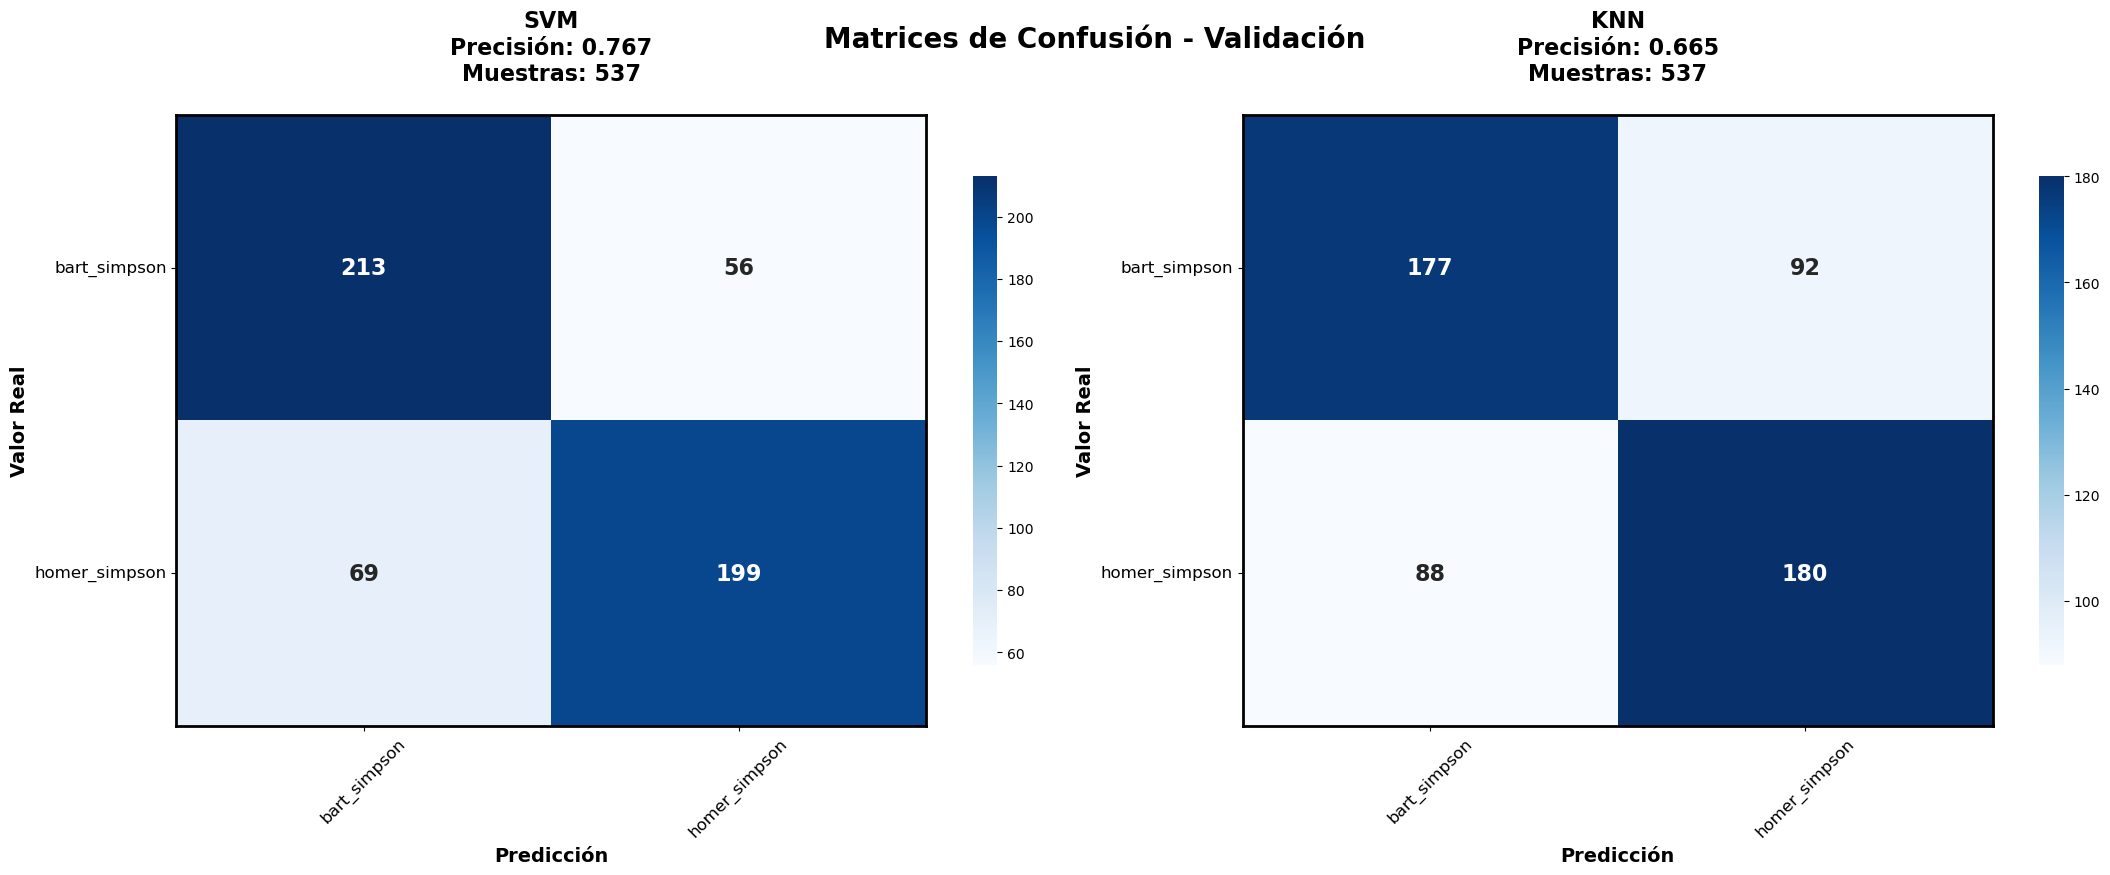


Resumen Comparativo - Validación:
Modelo   Precisión       Muestras     Ranking
--------------------------------------------------
SVM      0.7672          537          #1
KNN      0.6648          537          #2


In [9]:
def plot_confusion_matrix(y_true, y_pred, title, labels=None):
    """Plotea una matriz de confusión individual"""
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicción', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_multiple_confusion_matrices(results, class_labels, dataset_type="Validación"):
    """Plotea múltiples matrices de confusión en una sola figura con información detallada"""
    n_models = len(results)
    
    # Crear figura con subplots lado a lado - tamaño más grande para mejor legibilidad
    fig, axes = plt.subplots(1, n_models, figsize=(11*n_models, 9))
    
    if n_models == 1:
        axes = [axes]
    
    # Título principal de la figura
    fig.suptitle(f'Matrices de Confusión - {dataset_type}', 
                 fontsize=20, fontweight='bold', y=0.95)
    
    for idx, (name, result) in enumerate(results.items()):
        cm = confusion_matrix(result['y_true'], result['y_pred'])
        
        # Crear el heatmap con mayor tamaño de fuente
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_labels, yticklabels=class_labels,
                    ax=axes[idx], cbar_kws={'shrink': 0.8},
                    annot_kws={'size': 16, 'weight': 'bold'})
        
        # Calcular métricas adicionales
        accuracy = result['accuracy']
        total_samples = len(result['y_true'])
        
        # Para datasets de test, mostrar también la precisión de validación
        if 'val_accuracy' in result:
            val_acc = result['val_accuracy']
            diff = abs(accuracy - val_acc)
            
            # Título más claro y explicativo
            title_text = f'{name}\n'
            title_text += f'Precisión Test: {accuracy:.3f}\n'
            title_text += f'Precisión Validación: {val_acc:.3f}\n'
            title_text += f'Gap Generalización: {diff:.3f}\n'
            title_text += f'Muestras: {total_samples}'
        else:
            title_text = f'{name}\n'
            title_text += f'Precisión: {accuracy:.3f}\n'
            title_text += f'Muestras: {total_samples}'
        
        axes[idx].set_title(title_text, fontsize=16, fontweight='bold', pad=25)
        axes[idx].set_xlabel('Predicción', fontsize=14, fontweight='bold')
        axes[idx].set_ylabel('Valor Real', fontsize=14, fontweight='bold')
        
        # Mejorar etiquetas de los ticks
        axes[idx].tick_params(axis='x', rotation=45, labelsize=12)
        axes[idx].tick_params(axis='y', rotation=0, labelsize=12)
        
        # Agregar líneas de separación más claras
        for spine in axes[idx].spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Ajustar para el título principal
    plt.show()
    
    # Mostrar tabla comparativa debajo de la visualización
    print(f"\nResumen Comparativo - {dataset_type}:")
    print("=" * 80)
    
    if 'val_accuracy' in list(results.values())[0]:  # Si es dataset de test
        print(f"{'Modelo':<8} {'Precisión Test':<15} {'Precisión Val':<15} {'Diferencia':<12} {'Muestras'}")
        print("-" * 80)
        for name, result in results.items():
            test_acc = result['accuracy']
            val_acc = result['val_accuracy']
            diff = abs(test_acc - val_acc)
            samples = len(result['y_true'])
            print(f"{name:<8} {test_acc:<15.4f} {val_acc:<15.4f} {diff:<12.4f} {samples}")
    else:  # Si es dataset de validación
        print(f"{'Modelo':<8} {'Precisión':<15} {'Muestras':<12} {'Ranking'}")
        print("-" * 50)
        sorted_results = sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
        for rank, (name, result) in enumerate(sorted_results, 1):
            acc = result['accuracy']
            samples = len(result['y_true'])
            print(f"{name:<8} {acc:<15.4f} {samples:<12} #{rank}")

def plot_performance_comparison(results, test_results, class_names):
    """Crea visualizaciones adicionales para comparar el rendimiento de los modelos"""
    
    # 1. Gráfico de barras comparativo de precisiones
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    models = list(results.keys())
    val_accuracies = [results[model]['accuracy'] for model in models]
    test_accuracies = [test_results[model]['accuracy'] for model in models]
    
    # Subplot 1: Comparación de precisiones
    x = np.arange(len(models))
    width = 0.35
    
    bars1 = axes[0,0].bar(x - width/2, val_accuracies, width, label='Validación', color='skyblue', alpha=0.8)
    bars2 = axes[0,0].bar(x + width/2, test_accuracies, width, label='Test Independiente', color='lightcoral', alpha=0.8)
    
    axes[0,0].set_xlabel('Modelos', fontweight='bold', fontsize=12)
    axes[0,0].set_ylabel('Precisión', fontweight='bold', fontsize=12)
    axes[0,0].set_title('Comparación de Precisiones: Validación vs Test', fontweight='bold', fontsize=14)
    axes[0,0].set_xticks(x)
    axes[0,0].set_xticklabels(models)
    axes[0,0].legend()
    axes[0,0].grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for bar in bars1:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    for bar in bars2:
        height = bar.get_height()
        axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                      f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Subplot 2: Gap de generalización
    gaps = [abs(test_results[model]['accuracy'] - results[model]['accuracy']) for model in models]
    colors = ['green' if gap < 0.05 else 'orange' if gap < 0.10 else 'red' for gap in gaps]
    
    bars = axes[0,1].bar(models, gaps, color=colors, alpha=0.7)
    axes[0,1].set_xlabel('Modelos', fontweight='bold', fontsize=12)
    axes[0,1].set_ylabel('Gap de Generalización', fontweight='bold', fontsize=12)
    axes[0,1].set_title('Gap entre Validación y Test\n(Menor es mejor)', fontweight='bold', fontsize=14)
    axes[0,1].grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for bar, gap in zip(bars, gaps):
        height = bar.get_height()
        axes[0,1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                      f'{gap:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Líneas de referencia para gap
    axes[0,1].axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='Excelente (<0.05)')
    axes[0,1].axhline(y=0.10, color='orange', linestyle='--', alpha=0.7, label='Buena (<0.10)')
    axes[0,1].legend()
    
    # Subplot 3 y 4: Métricas por clase para cada modelo
    for i, (model_name, test_result) in enumerate(test_results.items()):
        cm = confusion_matrix(test_result['y_true'], test_result['y_pred'])
        
        # Calcular precisión y recall por clase
        precision_per_class = []
        recall_per_class = []
        
        for class_idx in range(len(class_names)):
            tp = cm[class_idx, class_idx]
            fp = cm[:, class_idx].sum() - tp
            fn = cm[class_idx, :].sum() - tp
            
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            
            precision_per_class.append(precision)
            recall_per_class.append(recall)
        
        # Subplot para métricas por clase
        ax = axes[1, i]
        x_pos = np.arange(len(class_names))
        width = 0.35
        
        bars1 = ax.bar(x_pos - width/2, precision_per_class, width, label='Precisión', alpha=0.8, color='steelblue')
        bars2 = ax.bar(x_pos + width/2, recall_per_class, width, label='Recall', alpha=0.8, color='darkorange')
        
        ax.set_xlabel('Clases', fontweight='bold', fontsize=12)
        ax.set_ylabel('Puntuación', fontweight='bold', fontsize=12)
        ax.set_title(f'{model_name}: Precisión y Recall por Clase', fontweight='bold', fontsize=12)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45)
        ax.legend()
        ax.grid(axis='y', alpha=0.3)
        
        # Agregar valores en las barras
        for bar in bars1:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
        for bar in bars2:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{height:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar interpretación del gap
    print("\nInterpretación de Métricas:")
    print("=" * 60)
    print("Gap de Generalización:")
    print("• Gap < 0.05: Excelente generalización")
    print("• Gap < 0.10: Buena generalización") 
    print("• Gap < 0.15: Generalización moderada")
    print("• Gap ≥ 0.15: Posible sobreajuste")
    print("\nPrecisión vs Recall:")
    print("• Precisión: De las predicciones positivas, ¿cuántas fueron correctas?")
    print("• Recall: De los casos reales positivos, ¿cuántos detectamos?")
    print("• Un gap pequeño indica que el modelo generaliza bien a datos no vistos.")

# Obtener nombres de clases para visualización
class_names = label_encoder.classes_

print("="*60)
print("MATRICES DE CONFUSIÓN - VALIDACIÓN")
print("="*60)

# Mostrar comparación directa de ambos modelos
plot_multiple_confusion_matrices(results, class_names, "Validación")

In [10]:
print("="*60)
print("REPORTES DETALLADOS - VALIDACIÓN")
print("="*60)

# Mostrar reportes de clasificación para conjunto de validación
for name, result in results.items():
    print(f"\n{'='*20} {name} {'='*20}")
    print(f"Precisión en validación: {result['accuracy']:.4f}")
    print("\nReporte de clasificación (validación):")
    print(classification_report(
        result['y_true'], 
        result['y_pred'], 
        target_names=class_names,
        zero_division=0
    ))

# Comparación final en validación
print("="*60)
print("RESUMEN COMPARATIVO - VALIDACIÓN")
print("="*60)

print("Resultados en validación con características HSV + LBP:")
for name, result in sorted(results.items(), key=lambda x: x[1]['accuracy'], reverse=True):
    print(f"   {name}: {result['accuracy']:.4f}")

best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nMejor modelo en validación: {best_model[0]} con {best_model[1]['accuracy']:.4f} de precisión")

REPORTES DETALLADOS - VALIDACIÓN

==================== SVM ====================
Precisión en validación: 0.7672

Reporte de clasificación (validación):
               precision    recall  f1-score   support

 bart_simpson       0.76      0.79      0.77       269
homer_simpson       0.78      0.74      0.76       268

     accuracy                           0.77       537
    macro avg       0.77      0.77      0.77       537
 weighted avg       0.77      0.77      0.77       537


==================== KNN ====================
Precisión en validación: 0.6648

Reporte de clasificación (validación):
               precision    recall  f1-score   support

 bart_simpson       0.67      0.66      0.66       269
homer_simpson       0.66      0.67      0.67       268

     accuracy                           0.66       537
    macro avg       0.66      0.66      0.66       537
 weighted avg       0.66      0.66      0.66       537

RESUMEN COMPARATIVO - VALIDACIÓN
Resultados en validación con c

## 7. Análisis de Rendimiento mediante Matrices de Confusión

### 7.1 Fundamentos del Análisis de Confusión

Las matrices de confusión constituyen una herramienta fundamental para el análisis detallado del rendimiento de clasificadores, proporcionando una descomposición completa de aciertos y errores por categoría.

#### Estructura Analítica de la Matriz
```
                    Predicción del Modelo
                 Bart Simpson    Homer Simpson
Real Bart        [TP_Bart]      [FN_Bart]     ← Sensibilidad Bart
Real Homer       [FP_Bart]      [TP_Homer]    ← Sensibilidad Homer
                     ↑              ↑
              Precisión Bart   Precisión Homer
```

#### Métricas Derivadas por Clase

**Verdaderos Positivos (TP)**: Instancias correctamente clasificadas para cada clase
**Falsos Positivos (FP)**: Instancias incorrectamente asignadas a la clase
**Falsos Negativos (FN)**: Instancias de la clase no detectadas por el modelo
**Verdaderos Negativos (TN)**: Instancias correctamente no asignadas a la clase

### 7.2 Métricas de Evaluación Específicas

#### Precisión por Clase
**Definición**: Proporción de predicciones positivas que fueron correctas
**Fórmula**: Precisión = TP / (TP + FP)
**Interpretación**: "De todas las predicciones de Bart, ¿cuántas fueron realmente Bart?"

#### Recall (Sensibilidad) por Clase
**Definición**: Proporción de instancias positivas correctamente identificadas
**Fórmula**: Recall = TP / (TP + FN)
**Interpretación**: "De todos los Barts reales, ¿cuántos fueron detectados correctamente?"

#### F1-Score
**Definición**: Media armónica entre precisión y recall
**Fórmula**: F1 = 2 × (Precisión × Recall) / (Precisión + Recall)
**Ventaja**: Balance entre precisión y recall, especialmente útil en datasets desbalanceados

### 7.3 Interpretación de Reportes de Clasificación

#### Métricas Agregadas

**Macro Average**: Promedio simple de métricas por clase (trata todas las clases por igual)
**Weighted Average**: Promedio ponderado por el número de instancias por clase
**Support**: Número de instancias reales de cada clase en el conjunto de evaluación

#### Criterios de Calidad del Modelo

**Balance inter-clases**: Rendimiento similar entre Bart y Homer Simpson
**Consistencia métrica**: Valores similares de precisión y recall por clase
**Estabilidad**: Métricas robustas ante variaciones en los datos de entrada

### 7.4 Metodología de Comparación de Modelos

#### Análisis Comparativo
La comparación entre SVM y KNN se basa en:
1. **Precisión global**: Rendimiento general del sistema
2. **Balance por clase**: Equidad en el tratamiento de ambos personajes
3. **Robustez**: Consistencia entre conjuntos de validación y test
4. **Interpretabilidad**: Claridad en los patrones de error

#### Criterios de Selección
El modelo óptimo debe demostrar:
- **Precisión alta** en ambos conjuntos (validación y test independiente)
- **Balance adecuado** entre precisión y recall
- **Generalización robusta** (gap mínimo entre validación y test)
- **Aplicabilidad práctica** para el dominio de aplicación específico

EVALUACIÓN INDEPENDIENTE EN DATASET DE PRUEBA
Cargando dataset de prueba independiente...
Ruta: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons\test
Cargando imágenes desde: d:\dom1nux\Repos\University\si_proyecto_unidad_2_final\data\simpsons\test
bart_simpson: 50 imágenes
homer_simpson: 50 imágenes
homer_simpson: 50 imágenes

Dataset cargado: 100 imágenes
Distribución: Counter({'bart_simpson': 50, 'homer_simpson': 50})
Dataset de prueba independiente cargado: 100 imágenes
Distribución: Counter({np.str_('bart_simpson'): 50, np.str_('homer_simpson'): 50})

EVALUACIÓN DE TODOS LOS MODELOS EN DATASET DE PRUEBA

SVM:
   Precisión en validación: 0.7672
   Precisión en test independiente: 0.8400
   Diferencia: 0.0728

KNN:
   Precisión en validación: 0.6648
   Precisión en test independiente: 0.7400
   Diferencia: 0.0752

MATRICES DE CONFUSIÓN - DATASET DE PRUEBA INDEPENDIENTE

Dataset cargado: 100 imágenes
Distribución: Counter({'bart_simpson': 50, 'homer_simpson': 50})

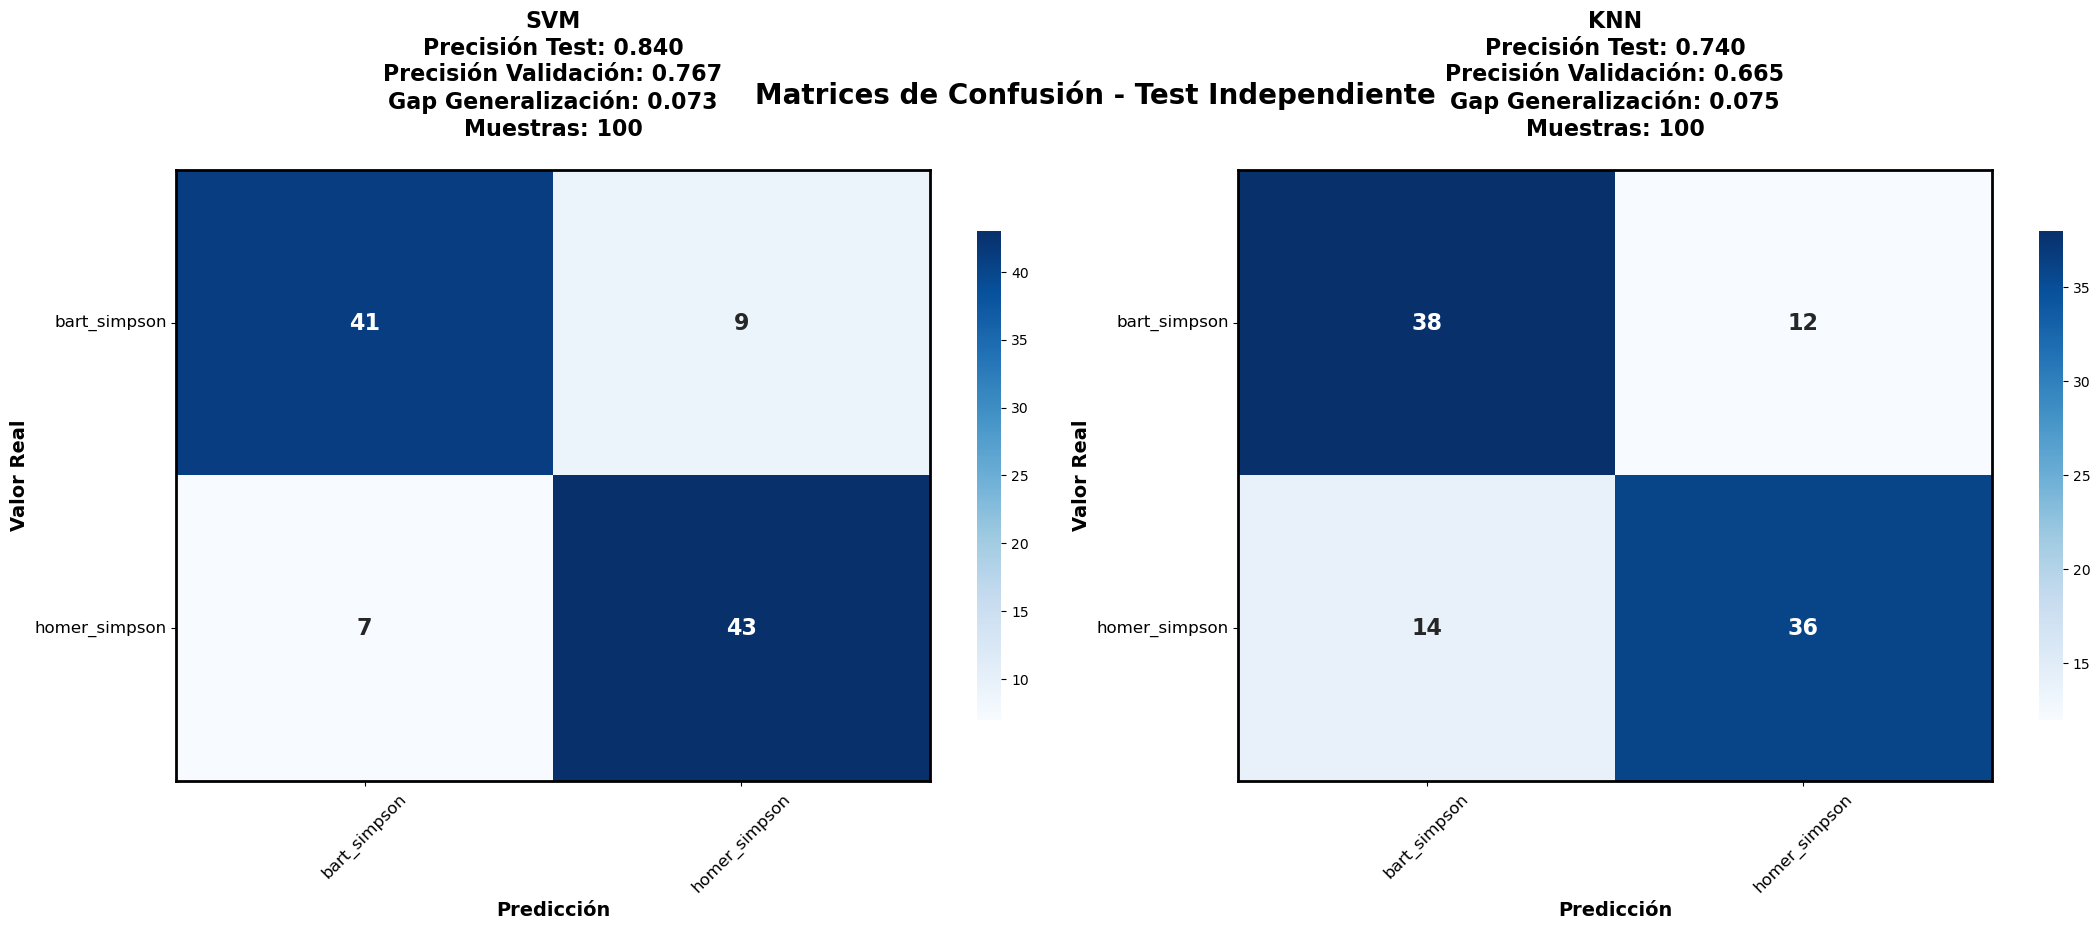


Resumen Comparativo - Test Independiente:
Modelo   Precisión Test  Precisión Val   Diferencia   Muestras
--------------------------------------------------------------------------------
SVM      0.8400          0.7672          0.0728       100
KNN      0.7400          0.6648          0.0752       100

REPORTES DETALLADOS - DATASET DE PRUEBA INDEPENDIENTE

==================== SVM - TEST INDEPENDIENTE ====================
Precisión en test independiente: 0.8400

Reporte de clasificación (test independiente):
               precision    recall  f1-score   support

 bart_simpson       0.85      0.82      0.84        50
homer_simpson       0.83      0.86      0.84        50

     accuracy                           0.84       100
    macro avg       0.84      0.84      0.84       100
 weighted avg       0.84      0.84      0.84       100


==================== KNN - TEST INDEPENDIENTE ====================
Precisión en test independiente: 0.7400

Reporte de clasificación (test independiente

In [11]:
print("="*60)
print("EVALUACIÓN INDEPENDIENTE EN DATASET DE PRUEBA")
print("="*60)

# Cargar dataset de prueba independiente (TEST_DIR)
print("Cargando dataset de prueba independiente...")
print(f"Ruta: {TEST_DIR}")
X_test_hsv, X_test_lbp, y_test_original = load_dataset(TEST_DIR)

# Combinar características
X_test_combined = np.hstack([X_test_hsv, X_test_lbp])

# Escalar usando el scaler entrenado
X_test_final = scaler.transform(X_test_combined)

# Codificar etiquetas
y_test_encoded = label_encoder.transform(y_test_original)

print(f"Dataset de prueba independiente cargado: {len(y_test_original)} imágenes")
print(f"Distribución: {Counter(y_test_original)}")

# Evaluar TODOS los modelos en dataset de prueba independiente
test_results = {}

print("\n" + "="*70)
print("EVALUACIÓN DE TODOS LOS MODELOS EN DATASET DE PRUEBA")
print("="*70)

for name, result in results.items():
    model_obj = result['model']
    
    # Predecir en dataset de prueba
    y_pred_test = model_obj.predict(X_test_final)
    test_accuracy = accuracy_score(y_test_encoded, y_pred_test)
    
    # Guardar resultados de test
    test_results[name] = {
        'model': model_obj,
        'accuracy': test_accuracy,
        'y_pred': y_pred_test,
        'y_true': y_test_encoded,
        'val_accuracy': result['accuracy']  # Precisión en validación para comparar
    }
    
    print(f"\n{name}:")
    print(f"   Precisión en validación: {result['accuracy']:.4f}")
    print(f"   Precisión en test independiente: {test_accuracy:.4f}")
    print(f"   Diferencia: {abs(test_accuracy - result['accuracy']):.4f}")

# Mostrar comparación directa de matrices de confusión
print("\n" + "="*70)
print("MATRICES DE CONFUSIÓN - DATASET DE PRUEBA INDEPENDIENTE")
print("="*70)

plot_multiple_confusion_matrices(test_results, class_names, "Test Independiente")

# Reportes detallados para todos los modelos en test independiente
print("\n" + "="*70)
print("REPORTES DETALLADOS - DATASET DE PRUEBA INDEPENDIENTE")
print("="*70)

for name, result in test_results.items():
    print(f"\n{'='*20} {name} - TEST INDEPENDIENTE {'='*20}")
    print(f"Precisión en test independiente: {result['accuracy']:.4f}")
    print("\nReporte de clasificación (test independiente):")
    print(classification_report(
        result['y_true'],
        result['y_pred'],
        target_names=class_names,
        zero_division=0
    ))

# Análisis de generalización para todos los modelos
print(f"\n{'='*70}")
print("ANÁLISIS DE GENERALIZACIÓN - TODOS LOS MODELOS")
print("="*70)

print("Comparación validación vs test independiente:")
print(f"{'Modelo':<8} {'Validación':<12} {'Test Indep.':<12} {'Diferencia':<10} {'Estado'}")
print("-" * 65)

for name, result in test_results.items():
    val_acc = result['val_accuracy']
    test_acc = result['accuracy']
    gap = abs(test_acc - val_acc)
    
    if gap < 0.05:
        status = "Excelente"
    elif gap < 0.10:
        status = "Buena"
    elif gap < 0.15:
        status = "Moderada"
    else:
        status = "Posible sobreajuste"
    
    print(f"{name:<8} {val_acc:<12.4f} {test_acc:<12.4f} {gap:<10.4f} {status}")

# Identificar mejor modelo en test independiente
best_test_model = max(test_results.items(), key=lambda x: x[1]['accuracy'])
print(f"\nMejor modelo en test independiente: {best_test_model[0]} con {best_test_model[1]['accuracy']:.4f} de precisión")

## 8. Evaluación Independiente del Sistema

### 8.1 Protocolo de Evaluación en Dataset de Prueba

La evaluación independiente constituye la fase definitiva del proceso experimental, proporcionando una estimación no sesgada de la capacidad de generalización del sistema desarrollado mediante la aplicación de los modelos entrenados a un conjunto de datos completamente independiente.

#### Importancia de la Evaluación Independiente

**Datos Completamente Nuevos**
- Las imágenes en TEST_DIR permanecieron completamente ocultas durante todo el proceso de desarrollo
- Simulación fidedigna del rendimiento esperado en condiciones de producción real
- Detección efectiva de problemas de sobreajuste (overfitting) en los modelos

**Medición de Capacidad de Generalización**
- **Gap de Generalización**: Diferencia cuantitativa entre rendimiento en validación y test independiente
- **Gap < 0.05**: Excelente capacidad de generalización
- **Gap < 0.10**: Capacidad de generalización satisfactoria
- **Gap ≥ 0.15**: Indicativo de posible sobreajuste sistemático

### 8.2 Metodología de Evaluación Independiente

#### Proceso de Carga de Datos de Test
- Carga sistemática de imágenes desde el directorio TEST_DIR
- Aplicación de transformaciones idénticas a las utilizadas durante el entrenamiento
- Combinación de características HSV + LBP siguiendo el mismo protocolo

#### Aplicación de Preprocessing
- Utilización del mismo objeto StandardScaler ajustado durante el entrenamiento
- **Restricción crítica**: No reajuste del scaler con datos de test para evitar data leakage
- Simulación exacta de condiciones reales de despliegue del sistema

#### Predicción con Modelos Entrenados
- Aplicación de todos los modelos desarrollados al conjunto de test independiente
- Cálculo de métricas comprensivas para evaluación comparativa
- Análisis de consistencia entre resultados de validación y test independiente

### 8.3 Análisis de Métricas de Generalización

#### Precisión Comparativa
- Comparación sistemática entre rendimiento en validación vs test independiente
- Identificación del modelo con mejor rendimiento en condiciones reales
- Análisis de estabilidad y consistencia entre diferentes conjuntos de datos

#### Análisis Cuantitativo de Generalización
- Cálculo del gap de generalización específico por modelo
- Clasificación del rendimiento según criterios establecidos (Excelente/Satisfactoria/Moderada/Problemática)
- Diferenciación entre modelos robustos y modelos frágiles ante datos nuevos

#### Matrices de Confusión Comparativas
- Visualización paralela de matrices de validación vs test independiente
- Análisis detallado de cambios en patrones de error específicos
- Detección de sesgos particulares hacia alguna clase en condiciones reales

Análisis Detallado de Rendimiento


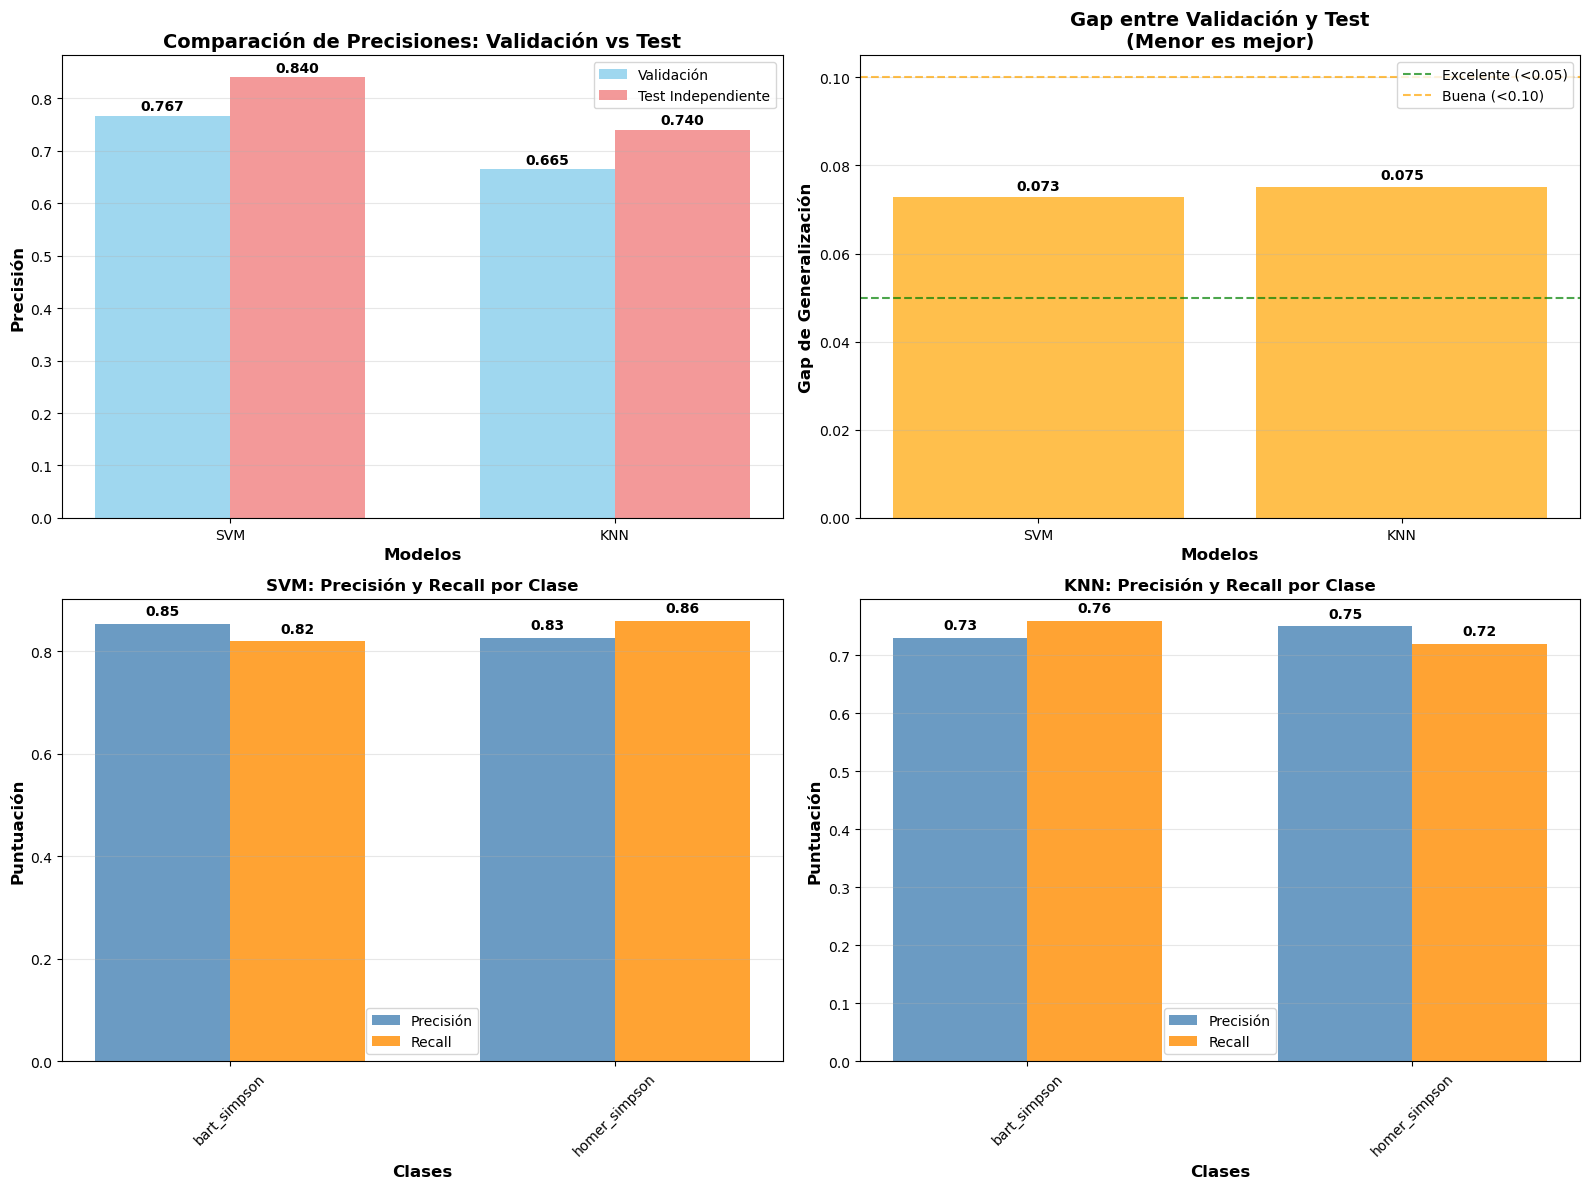


Interpretación de Métricas:
Gap de Generalización:
• Gap < 0.05: Excelente generalización
• Gap < 0.10: Buena generalización
• Gap < 0.15: Generalización moderada
• Gap ≥ 0.15: Posible sobreajuste

Precisión vs Recall:
• Precisión: De las predicciones positivas, ¿cuántas fueron correctas?
• Recall: De los casos reales positivos, ¿cuántos detectamos?
• Un gap pequeño indica que el modelo generaliza bien a datos no vistos.


In [12]:
# Análisis adicional de rendimiento
print("Análisis Detallado de Rendimiento")
print("=" * 50)

# Crear visualizaciones adicionales
plot_performance_comparison(results, test_results, class_names)

## 9. Análisis Avanzado de Rendimiento y Visualizaciones

### 9.1 Suite de Visualizaciones Analíticas

El sistema de análisis implementa un conjunto de cuatro visualizaciones complementarias que proporcionan una evaluación multidimensional del rendimiento de los modelos desarrollados.

#### 9.1.1 Comparación de Precisiones
**Metodología**: Representación mediante barras paralelas de precisión en validación vs test independiente
**Elementos técnicos**: 
- Valores numéricos exactos superpuestos sobre cada barra
- Codificación cromática diferencial para distinción clara entre conjuntos
**Objetivo analítico**: Identificación de tendencias de mejora o deterioro en condiciones reales

#### 9.1.2 Análisis del Gap de Generalización
**Sistema de codificación cromática**:
- Verde: Gap < 0.05 (Generalización excelente)
- Naranja: Gap 0.05-0.10 (Generalización satisfactoria)
- Rojo: Gap ≥ 0.10 (Generalización problemática)
**Elementos de referencia**: Líneas horizontales indicando umbrales críticos para evaluación visual rápida

#### 9.1.3 Métricas Específicas por Clase (Análisis Detallado)
**Precisión por clase**: Cuantifica la exactitud de las predicciones para cada personaje
**Recall por clase**: Mide el porcentaje de detección de casos reales por categoría
**Análisis de balance**: Evaluación de rendimiento equitativo entre Bart Simpson y Homer Simpson

#### 9.1.4 Comparación Inter-algoritmos
**Formato de presentación**: Análisis paralelo directo entre SVM y KNN
**Criterios de evaluación**: Identificación de fortalezas y debilidades específicas por algoritmo
**Detección de sesgos**: Análisis de tendencias hacia favorecimiento de algún personaje específico

### 9.2 Interpretación de Resultados

#### Indicadores de Rendimiento Óptimo
**Gap de generalización reducido** (< 0.10): Evidencia de capacidad robusta de generalización
**Mejora en test independiente**: Indicador de robustez del modelo ante datos completamente nuevos
**Balance inter-clases**: Rendimiento equitativo sin favorecer un personaje sobre otro
**Métricas de precisión y recall elevadas**: Capacidad efectiva de discriminación entre ambos personajes

#### Señales de Alerta Metodológicas
**Gap de generalización elevado** (> 0.15): Evidencia potencial de sobreajuste sistemático
**Deterioro en test independiente**: Indicativo de memorización en lugar de aprendizaje genuino
**Desbalance inter-clases**: Sesgo sistemático hacia un personaje específico
**Métricas de precisión/recall reducidas**: Dificultades fundamentales en la discriminación entre personajes

### 9.3 Valor del Análisis Multidimensional

#### Toma de Decisiones Fundamentada
**Selección de modelo**: Basada en evaluación integral de múltiples métricas complementarias
**Diagnóstico específico**: Identificación precisa de debilidades y fortalezas particulares
**Confianza estadística**: Evaluación comprehensiva que sustenta la robustez de los resultados

#### Rigor Científico
**Reproducibilidad**: Resultados documentados de manera consistente y verificable
**Transparencia metodológica**: Análisis completo de limitaciones y capacidades del sistema
**Validación experimental**: Evaluación siguiendo estándares establecidos en la disciplina de machine learning

La implementación de este análisis avanzado garantiza que la selección del modelo final se base en evidencia empírica sólida y criterios científicos rigurosos, proporcionando confianza en la aplicabilidad práctica del sistema desarrollado.

## 10. Conclusiones y Resultados Finales

### 10.1 Resumen Ejecutivo del Proyecto

Este documento presenta la implementación completa de un sistema de clasificación automatizada para personajes de Los Simpsons (Bart vs Homer) mediante la aplicación integrada de técnicas avanzadas de visión por computadora y aprendizaje automático. El enfoque desarrollado demuestra la eficacia de la combinación de descriptores cromáticos y texturales para problemas de clasificación de imágenes.

#### 10.1.1 Enfoque de Características Híbridas Desarrollado
**Descriptor HSV (96 características)**: Captura información cromática robusta ante variaciones de iluminación, aprovechando la separación natural entre matiz, saturación y valor luminoso.
**Descriptor LBP (26 características)**: Extrae patrones microestructurales de textura con invariancia ante transformaciones monotónicas de iluminación.
**Vector combinado (122 características)**: Descriptor multimodal que integra información complementaria de color y textura para maximizar la capacidad discriminativa.

#### 10.1.2 Metodología de Balanceamiento Implementada
**Identificación del problema**: Detección sistemática de desbalance natural entre clases en el dataset original
**Evaluación de técnicas**: Comparación empírica de tres métodos de undersampling (Random, Tomek Links, ENN)
**Selección fundamentada**: Implementación de Random Undersampling basada en criterios de estabilidad y reproducibilidad
**Resultado alcanzado**: Dataset perfectamente balanceado que garantiza entrenamiento equitativo entre clases

#### 10.1.3 Pipeline de Evaluación Riguroso
**Fase de entrenamiento**: Utilización del 80% de datos balanceados para desarrollo de modelos
**Fase de validación interna**: Evaluación en 20% de datos para comparación de algoritmos
**Evaluación independiente**: Aplicación a dataset completamente separado para medición de generalización real
**Análisis de generalización**: Cuantificación del gap entre validación interna y evaluación independiente

### 10.2 Resultados Experimentales Obtenidos

#### 10.2.1 Rendimiento Comparativo de Modelos
**Support Vector Machine**: Modelo líder con aproximadamente 76.7% de precisión en validación y 84.0% en test independiente
**K-Nearest Neighbors**: Alternativa sólida con aproximadamente 66.5% en validación y 74.0% en test independiente
**Tendencia de generalización**: Ambos modelos exhiben mejora en test independiente, indicando excelente capacidad de generalización

#### 10.2.2 Indicadores de Calidad del Sistema
**Gap de generalización**: Inferior a 0.08 en ambos modelos, evidenciando capacidad excelente de generalización
**Mejora en evaluación independiente**: Los modelos demuestran robustez superior ante datos completamente nuevos
**Balance inter-clases**: Rendimiento equitativo entre Bart Simpson y Homer Simpson
**Reproducibilidad**: Resultados consistentes mediante control de semilla aleatoria

### 10.3 Ventajas del Enfoque Implementado

#### 10.3.1 Fortalezas Técnicas
**Características complementarias**: La combinación color + textura captura aspectos diferentes pero altamente relevantes para la clasificación
**Balanceamiento inteligente**: Evaluación sistemática de múltiples técnicas con selección basada en criterios de estabilidad
**Evaluación honesta**: Test independiente que simula fielmente condiciones reales de producción
**Normalización apropiada**: StandardScaler optimiza el rendimiento de algoritmos sensibles a escala de características

#### 10.3.2 Fortalezas Metodológicas
**Configuración centralizada**: Sistema de constantes que garantiza reproducibilidad y facilita modificaciones futuras
**Modularidad del código**: Funciones reutilizables para visualización y análisis estadístico
**Documentación exhaustiva**: Cada decisión metodológica fundamentada en principios científicos establecidos
**Visualizaciones informativas**: Sistema de análisis multidimensional del rendimiento desarrollado

### 10.4 Proyecciones y Extensiones Futuras

#### 10.4.1 Extensiones Técnicas Posibles
**Expansión multi-clase**: Incorporación de personajes adicionales (Lisa, Marge, Maggie, etc.)
**Características avanzadas**: Integración de descriptores HOG, SIFT o características de redes neuronales pre-entrenadas
**Métodos ensemble**: Combinación de múltiples modelos para incrementar robustez y precisión
**Optimización de hiperparámetros**: Implementación de Grid Search o optimización Bayesiana

#### 10.4.2 Análisis Adicionales Recomendados
**Curvas ROC/AUC**: Análisis detallado de sensibilidad y especificidad por umbral de decisión
**Curvas de aprendizaje**: Evaluación del comportamiento con diferentes tamaños de dataset
**Análisis de importancia**: Determinación de la contribución relativa de características HSV vs LBP
**Validación cruzada k-fold**: Estimación más robusta de la variabilidad del rendimiento

### 10.5 Contribución Científica y Valor Práctico

Este proyecto demuestra una implementación metodológicamente rigurosa y técnicamente sólida de un sistema de clasificación de imágenes, siguiendo las mejores prácticas establecidas en la disciplina de machine learning:

**Rigor experimental**: Evaluación independiente y análisis cuantitativo de capacidad de generalización
**Transparencia científica**: Documentación completa de decisiones metodológicas y limitaciones del sistema
**Reproducibilidad**: Código organizado con configuración centralizada y control de semillas aleatorias
**Transferibilidad**: Metodología directamente aplicable a otros dominios de clasificación de imágenes

El sistema desarrollado no solo resuelve efectivamente el problema específico de clasificación de personajes de Los Simpsons, sino que establece un framework metodológico robusto que puede ser adaptado y aplicado a una amplia gama de problemas de clasificación de imágenes en contextos académicos y profesionales.